# Economical Cycle Timing

## Import libraries

In [29]:
#Data analysis
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

#Additional functionalities
from IPython.display import display
from calendar import monthrange
import itertools

#Custom python modules
import config

## Read the data

In [2]:
#Read the data
df_xl = pd.read_excel(config.excel_file)

#Show top rows
display(df_xl.head())

,date,price
0,1969-12-31,100.000
1,1970-01-30,94.249
2,1970-02-27,96.979
3,1970-03-31,97.075
4,1970-04-30,87.800


## Data transformations

In [3]:
#Monhly investment (can be any number)
inv = 100

#df_tf = Data Frame TransFormed
df_tf = df_xl.copy()

#Cumulative price
df_tf['price_cum'] = df_tf['price'].cumsum()

#Number of shares if bought with 10 000 dollars
df_tf['shares'] = inv / df_tf['price']

#Cumulative shares
df_tf['shares_cum'] = df_tf['shares'].cumsum()

#Year column
df_tf['year'] = df_tf['date'].dt.year

#Month column
df_tf['month'] = df_tf['date'].dt.month

#Order column by time
df_tf['order'] = df_tf['price'].index + 1

#Show top rows
display(df_tf.head())

,date,price,price_cum,shares,shares_cum,year,month,order
0,1969-12-31,100.000,100.000,1.000000,1.000000,1969,12,1
1,1970-01-30,94.249,194.249,1.061019,2.061019,1970,1,2
2,1970-02-27,96.979,291.228,1.031151,3.092170,1970,2,3
3,1970-03-31,97.075,388.303,1.030131,4.122302,1970,3,4
4,1970-04-30,87.800,476.103,1.138952,5.261254,1970,4,5


## Define the parameters

In [8]:
#First year of the simulations
first_year = 1997

#The last year of the simulation
last_year = 2009

#Duration of investment in years
dur_y = 10

#Create a range from the first and the last years
years = list(range(first_year, last_year + 1))

#The month when investment starts each year
month = 11

#Create a month range to loop each year
months = list(range(1, 13))

## Visualize

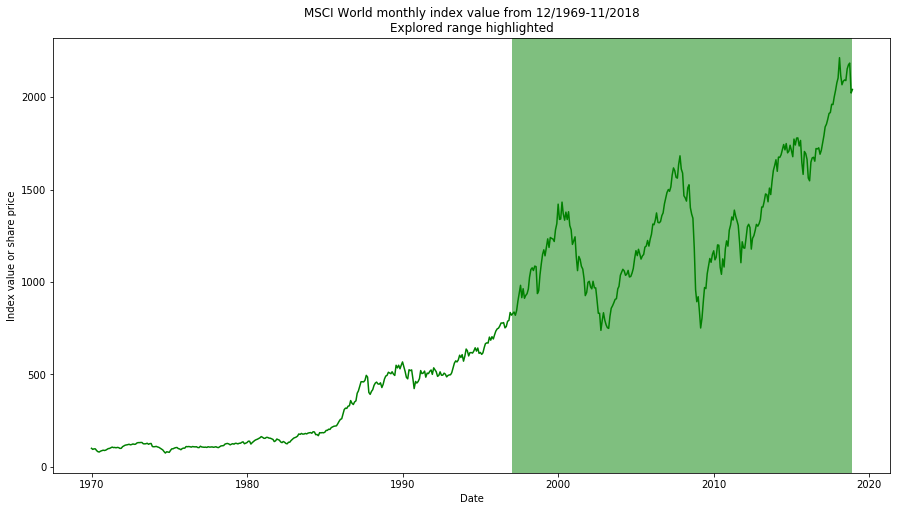

In [5]:
from datetime import date

y_margin = 500
value_max = df_tf["price"].max() + y_margin
value_min = 0 - y_margin/2

#First ordinal in datetime system
ord_0 = date(1, 1, 1).toordinal()

#Dates
x_min = date(first_year, 1, 1).toordinal() - ord_0
x_max = df_tf['date'].max().toordinal() - ord_0
x_days = x_max - x_min

#Initialie plot
fig, ax = plt.subplots(figsize=(15,8))

#Draw value line
ax.plot(df_tf["date"], df_tf["price"], color="green")

#Titles and labels
plt.title("MSCI World monthly index value from 12/1969-11/2018\nExplored range highlighted")
plt.ylabel("Index value or share price")
plt.xlabel("Date")

#Highlight explored range
highlights = []
rect_1 = Rectangle((x_min, value_min), x_days, value_max)
highlights.append(rect_1)
pc = PatchCollection(highlights, facecolor='green', alpha=0.5, edgecolor=None)
ax.add_collection(pc)

#Show
plt.show()


## The simulation

In [85]:
def f(x):

    names = {
        'cnt': x['is_profit'].count()
    }
    
    return pd.Series(names)

#Pass the series as argument. This function is pretty inefficient.
def longest_streak(df_arg):
    df = df_arg.copy()    

    #Remove all profitable months
    df = df[df['is_profit']==False]
    
    #Default streak count is 0
    n = 0
    
    #If there are at least one negative value
    if df.shape[0]!=0:

        
        go = True    
        
        #Do until data frame is empty
        while go:

            #Add one to the streak count
            n += 1
            
            #Calculate the difference to the next row
            df['diff'] = df['order'] - df['order'].shift(1)

            #Only leave consecutive values
            df = df[df['diff']==1]

            #display(df.head())            

            #Stop, if data frame is empty
            if df.shape[0]==0:
                go = False

    return n

def first_target(df_arg, target=10*inv):
    
    df = df_arg.copy()  
    
    first_dt = df['date'].min()
    
    df = df[df['profit_abs']>target]
    
    target_dt = df.iloc[0]['date']
        
    day_diff = target_dt - first_dt
    
    return day_diff

### Simulation

In [86]:
annual_dfs = []
kpi_dfs = []

#Loop each starting year
for y in years:    
    
    #Get cumulative sum of values when starting
    first_row = df_tf[(df_tf['year']==y) & (df_tf['month']==month)].iloc[0]
    first_shares = first_row['shares']
    first_shares_cum = first_row['shares_cum']
    first_date = first_row['date']
    first_order = first_row['order']

    #Get the last data of the investment
    last_m = str(month).zfill(2)
    last_y = y + dur_y
    last_date = np.datetime64('{}-{}-01'.format(last_y, last_m)) - np.timedelta64(1, 'D')
    
    #Get only dates after this year
    df_y = df_tf[(df_tf['date']>=first_date) & (df_tf['date']<=last_date)].copy()
    
    #Calculate KPIs    
    df_y['shares_cum_after'] = df_y['shares_cum'] - first_shares_cum + first_shares
    df_y['shares_cum_before'] = df_y['shares_cum_after'].shift(1)
    df_y['order_y'] = df_y['order'] - first_order + 1
    #Profit = Total sell sell price / Total investment
    df_y['profit_abs'] = (df_y['shares_cum_before'] * df_y['price']) - ((df_y['order_y'] - 1) * inv)
    df_y['profit_rate'] = (df_y['shares_cum_before'] * df_y['price']) / ((df_y['order_y'] - 1) * inv) - 1    
    df_y['profit_rate_annual'] = (df_y['profit_rate']+1) ** (1 / (df_y['order_y']/12/2))-1
    df_y['is_profit'] = np.where(df_y['profit_abs']>0, True, False)
    
    #Tag the year when investing started
    df_y['start_y'] = y

    #Calculate KPI values
    n_rows = df_y.shape[0]
    #Calculate months were shares would have made profit
    n_pos = np.where(df_y['profit_abs']>0, 1, 0).sum()
    #Calculate months were shares would NOT have made profit
    n_neg = np.where(df_y['profit_abs']<=0, 1, 0).sum()
    
    trgt = first_target(df_y, target=1000)
    
    longest_neg = longest_streak(df_y)
        
    #Note: First month is never positive or negative
    dict_kpi = [{
        'y': y,
        'n_rows': n_rows,
        'n_pos': n_pos,
        'n_neg': n_neg,
        'neg_rate': n_neg/n_rows,
        'longest_neg': longest_neg,
        'target_profit': trgt,
    }]
    
    df_kpi = pd.DataFrame(dict_kpi)
    
    #display(df_y.head())
        
    annual_dfs.append(df_y)
    kpi_dfs.append(df_kpi)
        
df_results = pd.concat(annual_dfs)
df_kpis = pd.concat(kpi_dfs)

#Show top rows
display(df_results.head())

display(df_kpis.head(13))

,date,price,price_cum,shares,shares_cum,year,month,order,shares_cum_after,shares_cum_before,order_y,profit_abs,profit_rate,profit_rate_annual,is_profit,start_y
335,1997-11-28,926.496,105742.029,0.107934,184.602602,1997,11,336,0.107934,NaN,1,NaN,NaN,NaN,False,1997
336,1997-12-31,936.591,106678.620,0.106770,184.709373,1997,12,337,0.214704,0.107934,2,1.089589,0.010896,0.138878,True,1997
337,1998-01-30,961.488,107640.108,0.104005,184.813378,1998,1,338,0.318709,0.214704,3,6.435068,0.032175,0.288332,True,1997
338,1998-02-27,1025.297,108665.405,0.097533,184.910911,1998,2,339,0.416242,0.318709,4,26.771583,0.089239,0.670083,True,1997
339,1998-03-31,1067.354,109732.759,0.093690,185.004600,1998,3,340,0.509932,0.416242,5,44.277469,0.110694,0.655208,True,1997


,longest_neg,n_neg,n_pos,n_rows,neg_rate,target_profit,y
0,34,39,80,120,0.325000,2590 days,1997
0,38,42,77,120,0.350000,2433 days,1998
0,39,55,64,120,0.458333,2068 days,1999
0,32,46,73,120,0.383333,1492 days,2000
0,14,31,88,120,0.258333,1186 days,2001
0,13,23,96,120,0.191667,1159 days,2002
0,18,30,89,120,0.250000,1160 days,2003
0,26,37,82,120,0.308333,2341 days,2004
0,30,38,81,120,0.316667,2619 days,2005
0,33,40,79,120,0.333333,2254 days,2006


## Visualize results

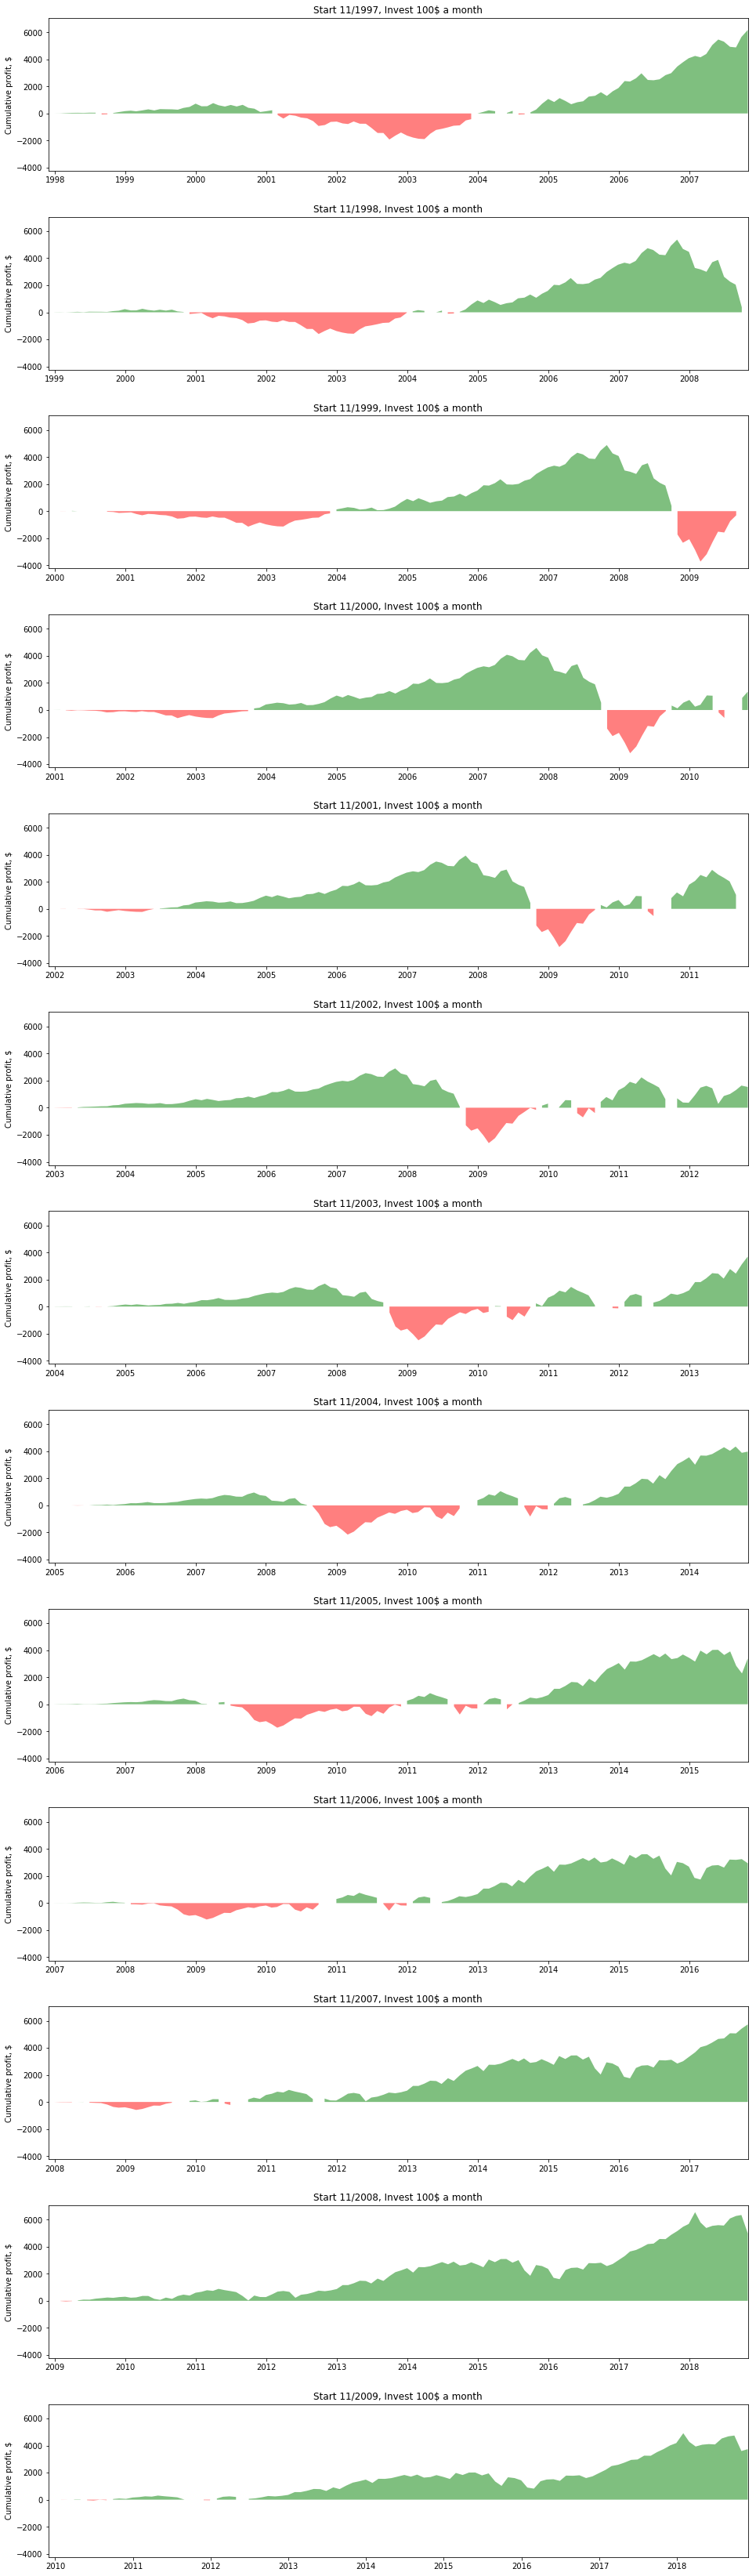

In [87]:
#Initialize plot
n_plots = len(years)
fig, ax = plt.subplots(n_plots, sharey=True, figsize=(16,24))

#Loop and visualize each year
i=0
for y in years:
    
    #Data Frame to visualize the year
    df_yvis = df_results[df_results['start_y']==y]
    
    #Draw the plot
    dates = df_yvis['date'].values.astype('datetime64[D]')
    profit = df_yvis['profit_abs']
    
    #Area chart
    ax[i].fill_between(dates, profit, where=profit<=0, facecolor='r', alpha=0.5)
    ax[i].fill_between(dates, profit, where=profit>=0, facecolor='g', alpha=0.5)
    
    #Subplot title
    ax[i].set_title("Start {}/{}, Invest {}$ a month".format(month, y, inv))
    ax[i].set_ylabel("Cumulative profit, $")
    
    #Subplot y limits
    #ax[i].set_ylim([-50, 100])
    
    #X limits
    x_min = df_yvis['date'].min()
    x_max= df_yvis['date'].max()        
    ax[i].set_xlim(x_min, x_max)
    
    plt.subplots_adjust(top=2, hspace=0.3)
    
    i += 1
    
plt.show()